In [1]:
import os
import json

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import numpy as np
import cv2 as cv
from skimage.io import imread, imsave
from skimage.util import img_as_float, img_as_float32, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import scipy.io as sio

from utils import weights_init_xavier
from models import PATvidx4
from mh_utils import MultiSeqSet, PatvidxrSlowflowSet, _project_rescale_grid
from mh_utils import _to_npimg, _to_tensor, _2d_patch_crop, _2d_patch_combine, move_pixel_value
from ext_utils import find_good_matching_points, _project_mesh_grid_to_indices_cube, move_pixel_value

In [2]:
# load mantis data
data_folder = '/groups/djbrady/minghao/22Oct21_mantis_data/'
img_fn_list = [fn for fn in os.listdir(data_folder) if fn.endswith('.jpeg')]
img_fn_list = sorted(img_fn_list)

lr_img = imread(os.path.join(data_folder, img_fn_list[10]))
hr_img_list = [imread(os.path.join(data_folder, img_fn_list[a])) for a in list(range(19)) if a!=10]

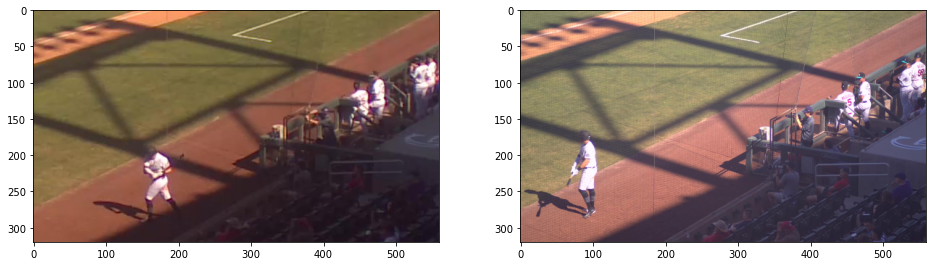

(320, 560, 3)


In [3]:
# select one pair
# hr_img = hr_img_list[3]
# lr_cropped = lr_img[940:1276,994:1582]
hr_img = hr_img_list[-1]
lr_cropped_ud = lr_img[983:1303,1950:2510]
# pre-downsample, as the original lr image is blury
#lr_cropped = cv.resize(lr_cropped_ud, None, None, 0.5, 0.5, interpolation=cv.INTER_AREA)
lr_cropped = lr_cropped_ud

hr_downscaled = cv.resize(hr_img, (lr_cropped.shape[1], lr_cropped.shape[0]), interpolation=cv.INTER_AREA)

########## dummy input ##########
#lr_cropped = hr_downscaled
#################################


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(lr_cropped)
axes[1].imshow(hr_downscaled)
plt.show()
print(lr_cropped.shape)

In [4]:
# geometric correspondence
res_gap = 4

pts1, pts2 = find_good_matching_points(cv.cvtColor(lr_cropped, cv.COLOR_RGB2GRAY), 
                                       cv.cvtColor(hr_downscaled, cv.COLOR_RGB2GRAY))
M_l2h, _ = cv.findHomography(pts1.reshape(-1,1,2),
                             pts2.reshape(-1,1,2),
                             cv.RANSAC, 5.0)
M_h2l, _ = cv.findHomography(pts2.reshape(-1,1,2),
                             pts1.reshape(-1,1,2),
                             cv.RANSAC, 5.0)
M_up4 = np.array([[4, 0, 0], 
                  [0, 4, 0],
                  [0, 0, 1]])

lr_cropped = img_as_float32(lr_cropped)
hr_downscaled = img_as_float32(hr_downscaled)
hr_up4 = img_as_float32(cv.resize(hr_img, (lr_cropped.shape[1]*res_gap, lr_cropped.shape[0]*res_gap), cv.INTER_AREA))
lr_tuned = move_pixel_value(img_as_float32(lr_cropped), hr_up4.mean(), hr_up4.std())

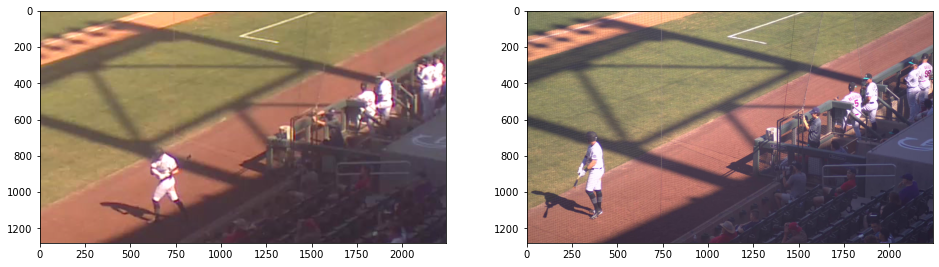

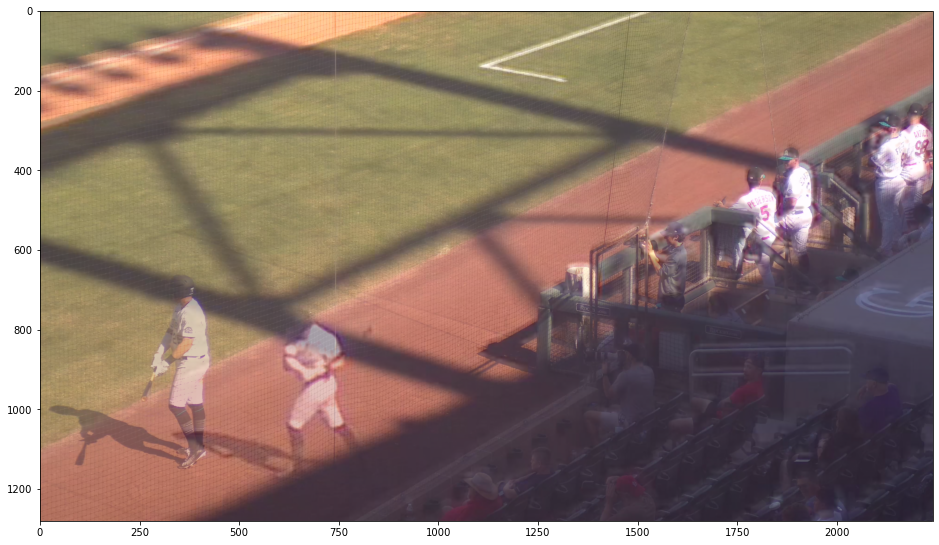

In [5]:
# matchin demo, without homography
lr_up4_tuned = cv.resize(lr_tuned, (hr_up4.shape[1], hr_up4.shape[0]), interpolation=cv.INTER_CUBIC)
lr_up4_tuned = np.clip(lr_up4_tuned, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(lr_up4_tuned)
axes[1].imshow(hr_up4)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(16, 12))
axes.imshow(lr_up4_tuned/2 + hr_up4/2)
plt.show()

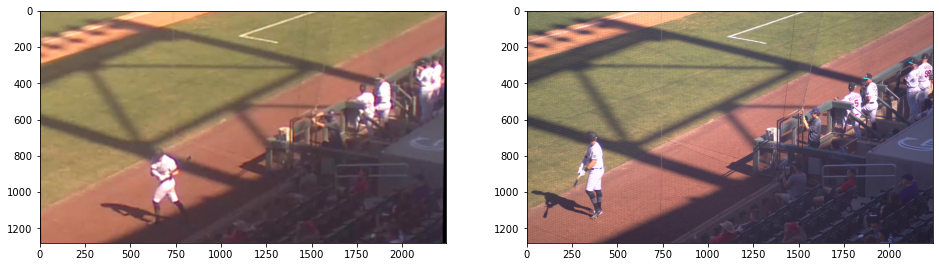

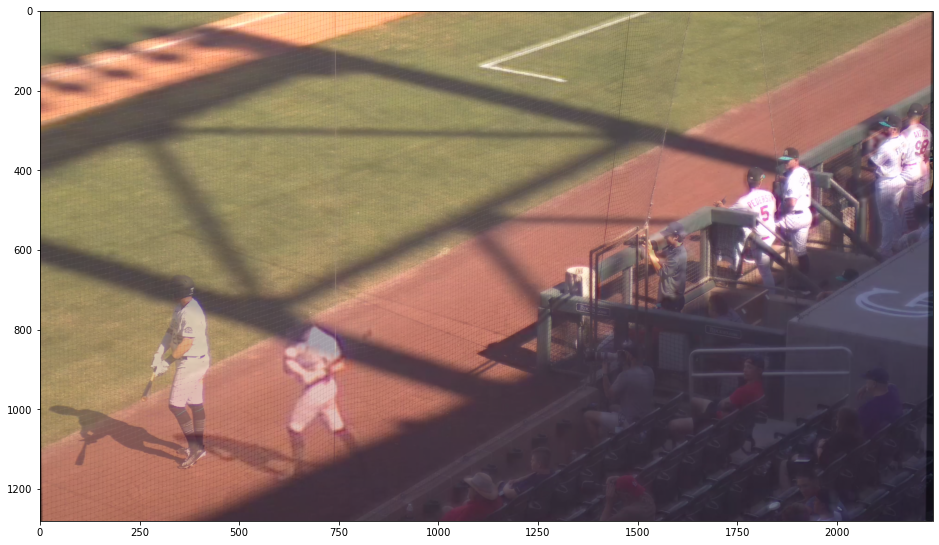

In [6]:
# matching demo, with homography
lr_up4_tuned = cv.warpPerspective(lr_tuned, np.array(M_up4@M_l2h), (hr_up4.shape[1], hr_up4.shape[0]))
lr_up4_tuned = np.clip(lr_up4_tuned, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(lr_up4_tuned)
axes[1].imshow(hr_up4)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(16, 12))
axes.imshow(lr_up4_tuned/2 + hr_up4/2)
plt.show()

In [7]:
# lr_list, g(lr), r(down_hr), b(down_hr)
#lr_list = [lr_cropped[...,1], hr_downscaled[...,0], hr_downscaled[...,2]]
lr_list = [lr_tuned[...,1], lr_tuned[...,0], lr_tuned[...,2]]

# hr
hr = cv.cvtColor(hr_up4, cv.COLOR_RGB2GRAY)

In [8]:
lr_hw = 2
hr_hw = 16
tgt_mn = (4, 4)
pad = hr_hw*res_gap

# crop input to patches
lr_stack_list = [_2d_patch_crop(img, tgt_mn, pad//res_gap) for img in lr_list]
hr_stack = _2d_patch_crop(hr, tgt_mn, pad)

In [9]:
# find rough correspondence. no homography
bs, h, w = lr_stack_list[0].shape
lr_yys, lr_xxs = _project_rescale_grid((w,h), (w,h), lr_hw, 1)
hr_yys, hr_xxs = _project_rescale_grid((w,h), (w,h), hr_hw, 1)
pos_tuple = (np.stack([lr_xxs, lr_yys], axis=0).astype(np.int16), 
             np.stack([lr_xxs, lr_yys], axis=0).astype(np.int16), 
             np.stack([hr_xxs, hr_yys], axis=0).astype(np.int16))

In [10]:
#%%script false --no-raise-error
# prepare netwrk
device = 'cuda:0'
weight_file = './weights/best.pth.tar'
pretrained_dict = torch.load(weight_file)
print("Loading weight from: {:s}. It's epoch {:d} with validation PSNR {:.2f}".format(weight_file, pretrained_dict['epoch'], pretrained_dict['psnr']))

net = PATvidx4().to(device)
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
net.load_state_dict(pretrained_dict['state_dict'])

Loading weight from: ./weights/best.pth.tar. It's epoch 100 with validation PSNR 28.92


<All keys matched successfully>

In [11]:
# go through network
torch.cuda.empty_cache()
# loop through patches
predp_list = []
for lr1p, lr2p, lr3p, hrp in zip(*lr_stack_list, hr_stack):
    # convert one patch set to tensors
    lr_ins = [_to_tensor(img)[None].to(device) for img in (lr1p, lr2p, lr3p)]
    hr_in = _to_tensor(hrp)[None].to(device)
    #gt_in = _to_tensor(gtp)[None].to(device)
    poss = [torch.from_numpy(pos[np.newaxis,...]).to(device) for pos in pos_tuple]
    # go through network
    with torch.no_grad():
        predp, _ = net(lr_ins, hr_in, 0, poss) # (1, 3, ph, pw)
        predp_list.append(_to_npimg(predp[0].cpu()))
# clean GPU memory
torch.cuda.empty_cache()

In [12]:
# combine pred patches
pred = _2d_patch_combine(np.array(predp_list), tgt_mn, pad)
# put back channels
#pred = pred[...,np.array([1,0,2])]
# clip
pred = np.clip(pred, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


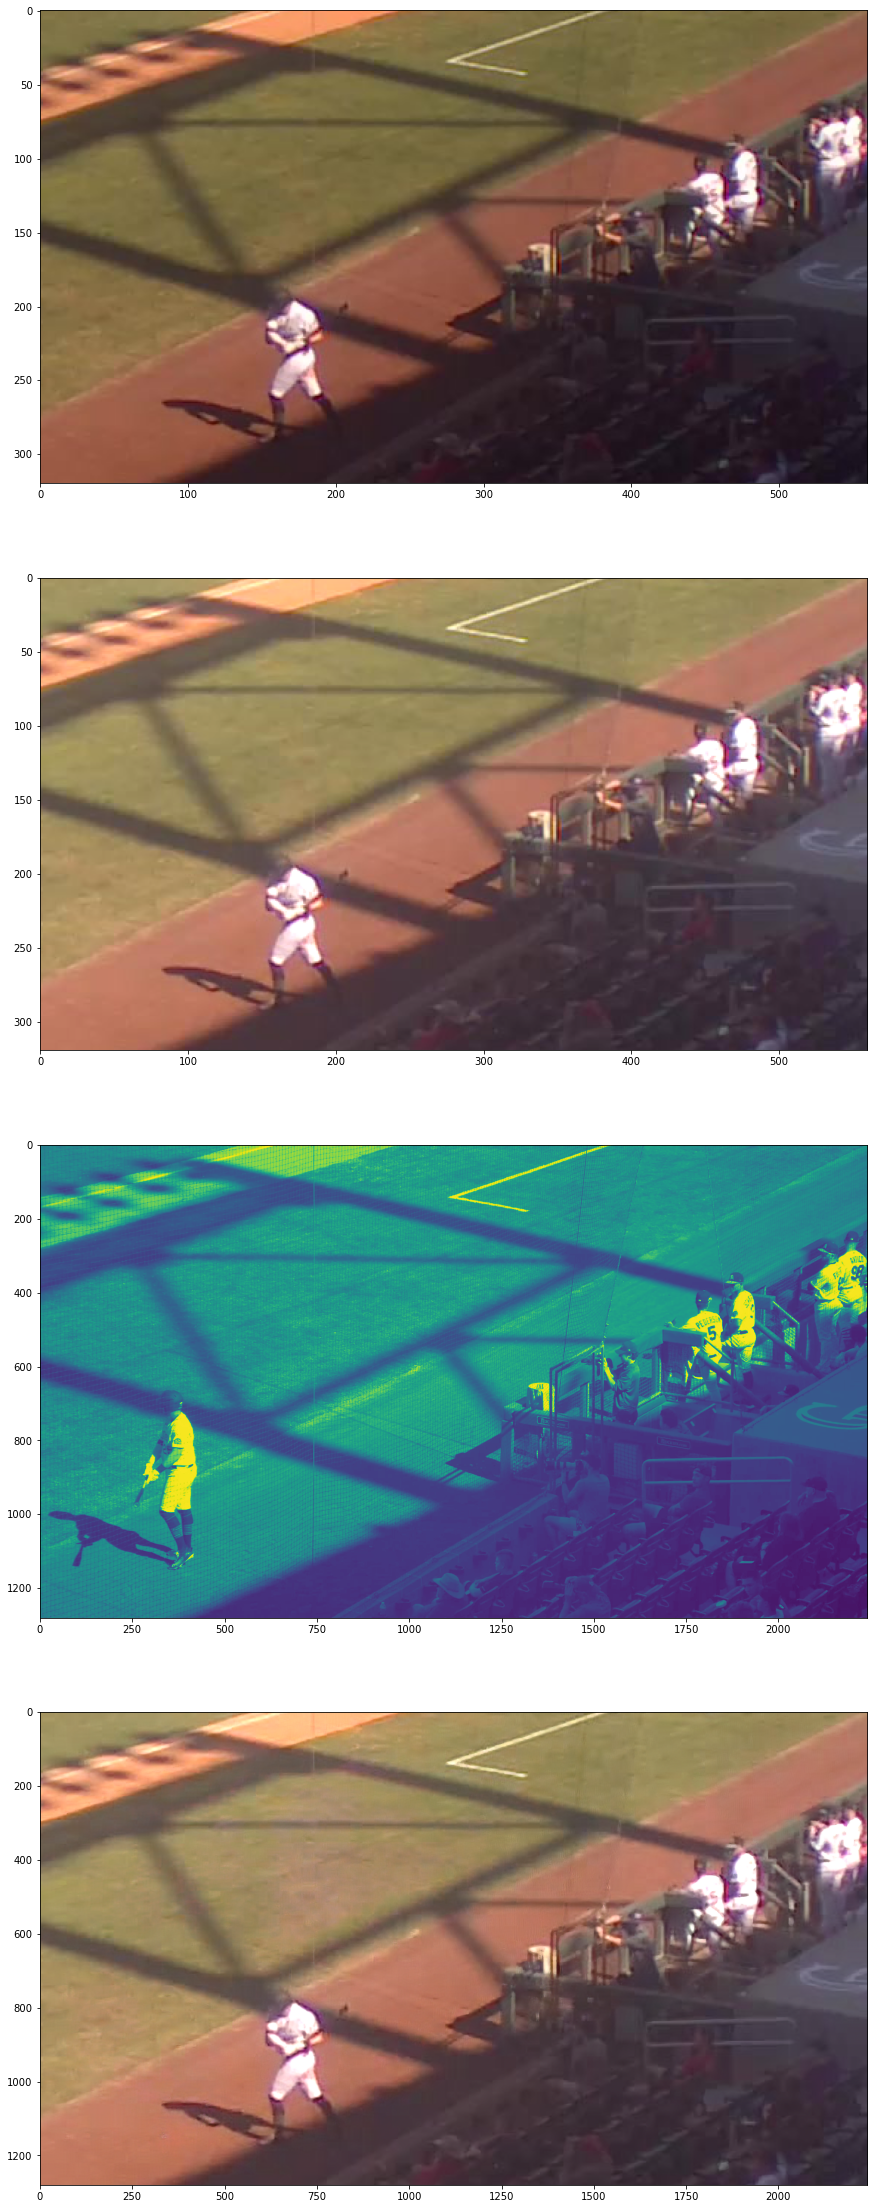

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(16, 40))
axes[0].imshow(lr_cropped_ud)
axes[1].imshow(lr_tuned)
axes[2].imshow(hr)
axes[3].imshow(pred)
plt.show()

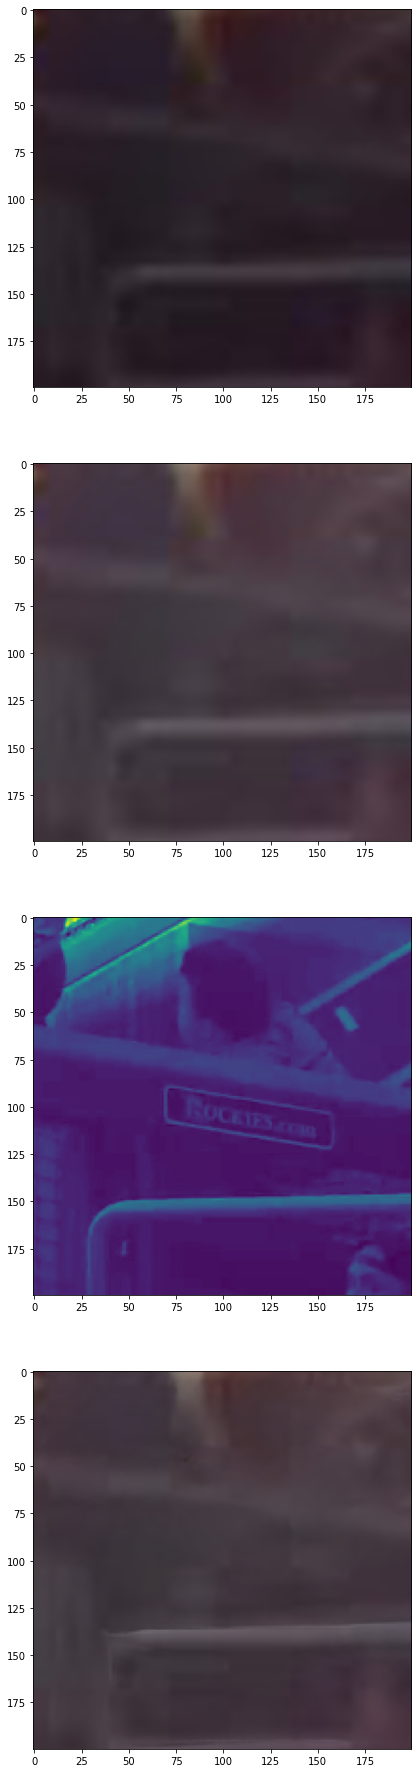

In [14]:
aoi = (slice(700,900), slice(1600, 1800))
fig, axes = plt.subplots(4, 1, figsize=(8, 32))
axes[0].imshow(cv.resize(lr_cropped_ud, (hr_up4.shape[1], hr_up4.shape[0]), interpolation=cv.INTER_CUBIC)[aoi])
axes[1].imshow(cv.resize(lr_tuned, (hr_up4.shape[1], hr_up4.shape[0]), interpolation=cv.INTER_CUBIC)[aoi])
axes[2].imshow(hr[aoi])
axes[3].imshow(pred[aoi])
plt.show()